In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataflow import df_train, df_test, df_geography, df_product

# 1. Kiểm chứng các tính chất chuỗi thời gian

In [2]:
# Kết nối tự nhiên giữa các bảng
df = df_train.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901561 entries, 0 to 901560
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ProductID  901561 non-null  int64         
 1   Date       901561 non-null  datetime64[ns]
 2   Zip        901561 non-null  int64         
 3   Units      901561 non-null  int64         
 4   Revenue    901561 non-null  float64       
 5   COGS       901561 non-null  float64       
 6   City       901561 non-null  object        
 7   State      901561 non-null  object        
 8   Region     901561 non-null  object        
 9   District   901561 non-null  object        
 10  Category   901561 non-null  object        
 11  Segment    901561 non-null  object        
 12  Product    901561 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 89.4+ MB


## 1.1. Trực quan hóa dữ liệu theo thời gian

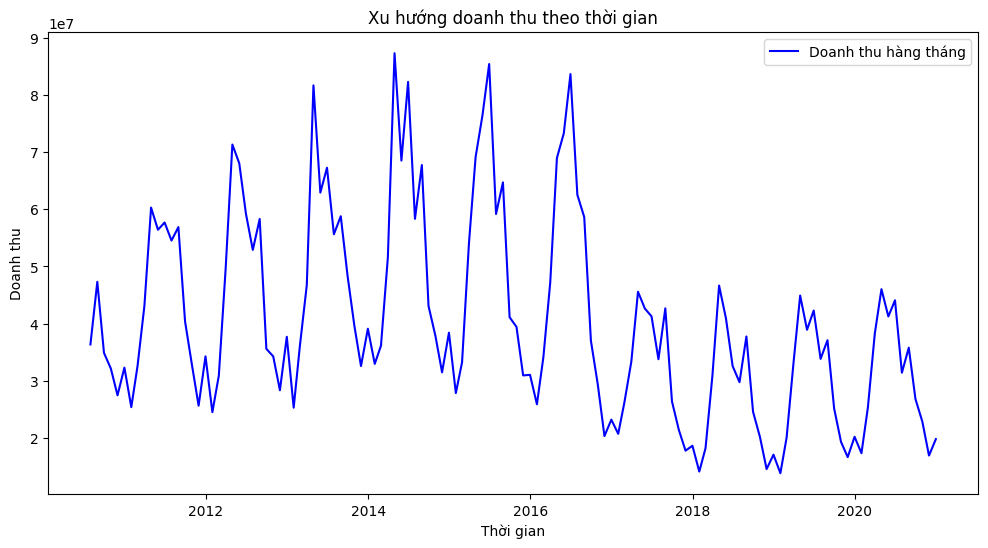

In [5]:
# Gom nhóm theo tháng
df_monthly = df.groupby(pd.Grouper(key='Date', freq='ME')).agg({'Revenue': 'sum', 'Units': 'sum'}).reset_index()

# Vẽ biểu đồ xu hướng doanh thu theo thời gian
plt.figure(figsize=(12,6))
plt.plot(df_monthly['Date'], df_monthly['Revenue'], label='Doanh thu hàng tháng', color='blue')
plt.title("Xu hướng doanh thu theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("Doanh thu")
plt.legend()
plt.show()

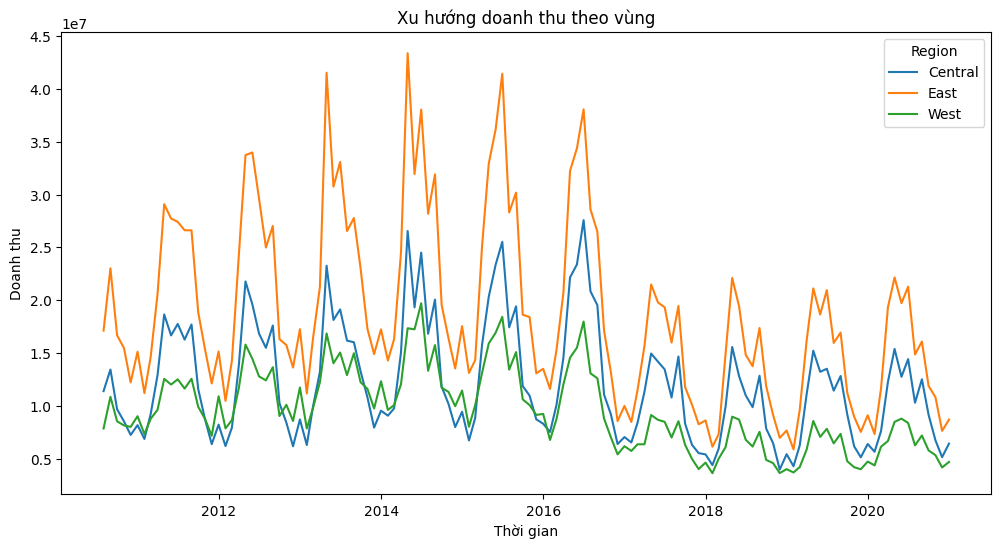

In [9]:
import seaborn as sns

# Gom nhóm theo tháng và vùng
df_region_monthly = df.groupby([pd.Grouper(key='Date', freq='ME'), 'Region']).agg({'Revenue': 'sum'}).reset_index()

# Vẽ biểu đồ xu hướng doanh thu theo từng vùng
plt.figure(figsize=(12,6))
sns.lineplot(data=df_region_monthly, x='Date', y='Revenue', hue='Region')
plt.title("Xu hướng doanh thu theo vùng")
plt.xlabel("Thời gian")
plt.ylabel("Doanh thu")
plt.show()

### a. Kiểm chứng hệ số tương quan Pearson

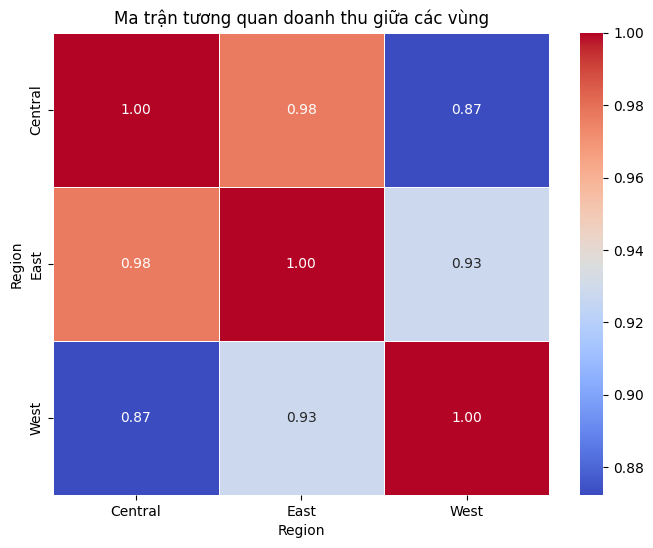

In [14]:
# Tạo bảng doanh thu theo từng vùng
df_pivot = df_region_monthly.pivot(index="Date", columns="Region", values="Revenue")

# Tính ma trận tương quan
corr_matrix = df_pivot.corr()

# Vẽ biểu đồ heatmap cho ma trận tương quan
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Ma trận tương quan doanh thu giữa các vùng")
plt.show()

- Biểu đồ heatmap thể hiện ma trận tương quan giữa các vùng Central, East, và West.
- Hệ số tương quan giữa Central và East là 0.98, giữa East và West là 0.93, và giữa Central và West là 0.87.
- Điều này chỉ ra rằng doanh thu giữa các vùng có mối liên hệ rất mạnh. Khi doanh thu ở một vùng tăng, doanh thu ở vùng khác cũng có xu hướng tăng theo.
- Mối liên hệ mạnh như vậy có thể do các yếu tố tác động chung như xu hướng tiêu dùng theo mùa vụ, chính sách giá, hoặc chiến dịch marketing đồng nhất trên toàn quốc.

⏩ **Nhận xét:** Do mức tương quan quá cao, dự báo doanh thu của một vùng có thể hỗ trợ cho việc dự báo các vùng khác. Nếu ta có dữ liệu tốt của một vùng, có thể sử dụng để dự đoán vùng khác.

### b. Kiểm chứng tương quan chéo

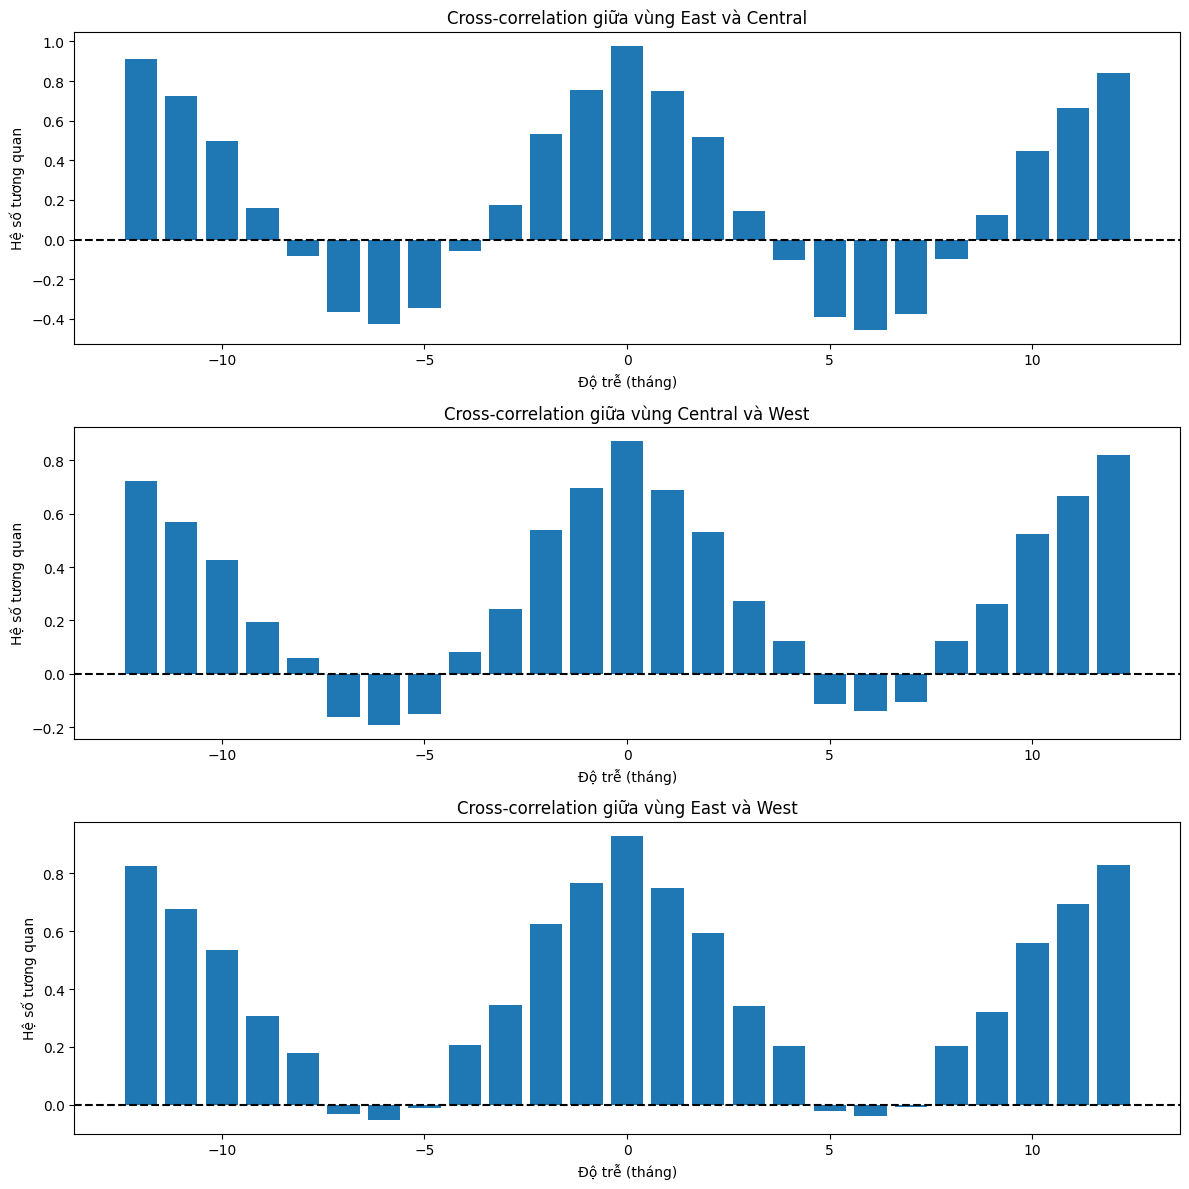

In [18]:
# Chọn các cặp vùng để kiểm tra cross-correlation
pairs = [('East', 'Central'), ('Central', 'West'), ('East', 'West')]

# Tạo figure với 3 subplot
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Duyệt qua từng cặp vùng
for i, (region1, region2) in enumerate(pairs):
    series1 = df_pivot[region1].dropna()
    series2 = df_pivot[region2].dropna()
    
    # Kiểm tra và căn chỉnh độ dài chuỗi thời gian
    min_length = min(len(series1), len(series2))
    series1, series2 = series1.iloc[:min_length], series2.iloc[:min_length]

    # Tính cross-correlation
    lags = range(-12, 13)  # Xem xét độ trễ trong khoảng 12 tháng
    cross_corr = [series1.corr(series2.shift(lag)) for lag in lags]

    # Vẽ biểu đồ cross-correlation
    axes[i].bar(lags, cross_corr)
    axes[i].set_title(f"Cross-correlation giữa vùng {region1} và {region2}")
    axes[i].set_xlabel("Độ trễ (tháng)")
    axes[i].set_ylabel("Hệ số tương quan")
    axes[i].axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()


- Biểu đồ cột thể hiện hệ số cross-correlation giữa doanh thu của các cặp vùng East-Central, Central-West, và East-West với độ trễ từ -12 đến 12 tháng.
- Hệ số cao nhất (~1.0) xảy ra ở độ trễ = 0 tháng, nghĩa là hai vùng này có xu hướng thay đổi đồng thời.
- Một số độ trễ dương (+1, +2, …) và âm (-1, -2, …) cũng có hệ số tương quan khá cao, điều này cho thấy đôi khi có thể có sự chậm trễ nhẹ về phản ứng doanh thu giữa các vùng, nhưng không đáng kể.

⏩ **Nhận xét:** Vì doanh thu ở các cặp vùng có biến động đồng thời, có thể dùng mô hình Vector AutoRegression (VAR) để dự báo hai vùng cùng lúc thay vì dự báo riêng lẻ.

### c. Phân tích thành phần chính (PCA)

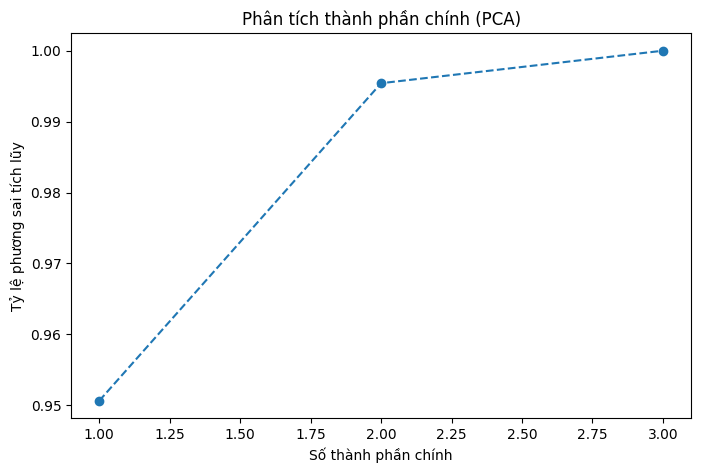

Trọng số của các vùng trong PC1:
[0.57710379 0.58820158 0.56654224]


In [16]:
from sklearn.decomposition import PCA

# Chuẩn hóa dữ liệu
df_pivot_norm = (df_pivot - df_pivot.mean()) / df_pivot.std()

# Áp dụng PCA
pca = PCA(n_components=3)
pca.fit(df_pivot_norm.dropna())

# Vẽ biểu đồ tỷ lệ phương sai tích lũy
plt.figure(figsize=(8,5))
plt.plot(range(1, 4), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel("Số thành phần chính")
plt.ylabel("Tỷ lệ phương sai tích lũy")
plt.title("Phân tích thành phần chính (PCA)")
plt.show()

# Hiển thị trọng số của mỗi vùng trong thành phần chính đầu tiên
print("Trọng số của các vùng trong PC1:")
print(pca.components_[0])

Biểu đồ tỷ lệ phương sai tích lũy (explained variance ratio) cho thấy:

- Thành phần chính đầu tiên (PC1) chiếm khoảng 95% phương sai, có nghĩa là gần như toàn bộ biến động doanh thu giữa các vùng có thể được giải thích chỉ bằng một yếu tố chính.
- Thành phần chính thứ hai (PC2) nâng tổng tỷ lệ lên gần 100%, nghĩa là chỉ cần 2 thành phần chính là có thể tái tạo toàn bộ thông tin ban đầu.

## 1.2. Kiểm tra tính dừng (Stationarity)

In [13]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_monthly['Revenue'])
print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])

if adf_result[1] > 0.05:
    print("Chuỗi không dừng")
else:
    print("Chuỗi dừng")

ADF Statistic: -0.603644
p-value: 0.870156
Chuỗi không dừng


In [8]:
df_monthly['Revenue_diff'] = df_monthly['Revenue'].diff()

# Kiểm định ADF sau khi lấy hiệu sai
adf_result_diff = adfuller(df_monthly['Revenue_diff'].dropna())
print("ADF Statistic after differencing: %f" % adf_result_diff[0])
print("p-value after differencing: %f" % adf_result_diff[1])

if adf_result_diff[1] > 0.05:
    print("Chuỗi vẫn không dừng, cần tiếp tục lấy hiệu sai")
else:
    print("Chuỗi đã dừng, có thể áp dụng mô hình dự báo")

ADF Statistic after differencing: -4.117726
p-value after differencing: 0.000905
Chuỗi đã dừng, có thể áp dụng mô hình dự báo


## 1.3. Kiểm tra yếu tố mùa vụ (Seasonality)

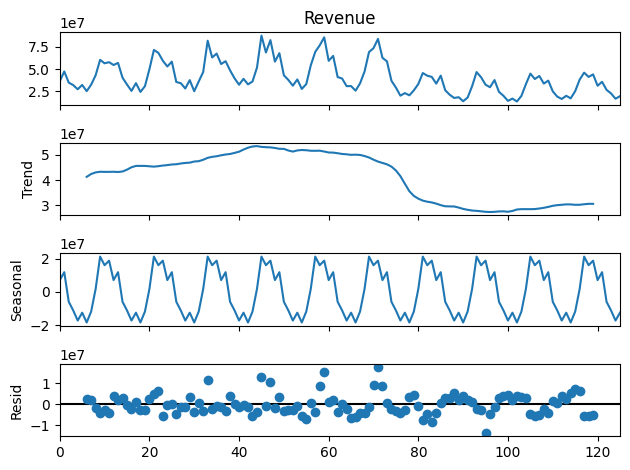

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Sử dụng seasonal_decompose với khoảng chu kỳ là 12 tháng
result = seasonal_decompose(df_monthly['Revenue'], model='additive', period=12)
result.plot()
plt.show()

Biểu đồ trên thể hiện kết quả phân rã doanh thu (Revenue) thành các thành phần chính:

1. Chuỗi gốc (Revenue): Doanh thu có dao động theo thời gian, với các biến động rõ ràng.

2. Xu hướng (Trend):

- Tăng dần trong nửa đầu chuỗi → Có thể do thị trường mở rộng hoặc tăng trưởng tự nhiên.
- Sau đó, xu hướng giảm xuống → Có thể do suy thoái kinh tế, thay đổi chính sách giá, hoặc mất thị phần.

3. Thành phần mùa vụ (Seasonal):

- Có chu kỳ lặp lại ổn định theo từng giai đoạn → Điều này chỉ ra rằng doanh thu có tính mùa vụ rõ ràng.
- Có thể liên quan đến kỳ nghỉ lễ, xu hướng tiêu dùng theo mùa.

4. Phần dư (Residual):

- Các dao động ngẫu nhiên (nhiễu) không được giải thích bởi xu hướng hoặc mùa vụ.
- Một số điểm có biên độ lớn → Có thể là do các sự kiện đột xuất như khuyến mãi lớn hoặc sự kiện bất ngờ.

In [19]:
# Kiểm định ADF trên phần dư
adf_test_resid = adfuller(result.resid.dropna())
print(f"ADF Statistic: {adf_test_resid[0]}")
print(f"p-value: {adf_test_resid[1]}")

if adf_test_resid[1] > 0.05:
    print("Phần dư chưa dừng, có thể cần tiếp tục xử lý")
else:
    print("Phần dư đã dừng, có thể sử dụng trong mô hình dự báo")

ADF Statistic: -5.134789329942951
p-value: 1.1928189281943253e-05
Phần dư đã dừng, có thể sử dụng trong mô hình dự báo


## 1.4. Kiểm tra tự tương quan (ACF & PACF)

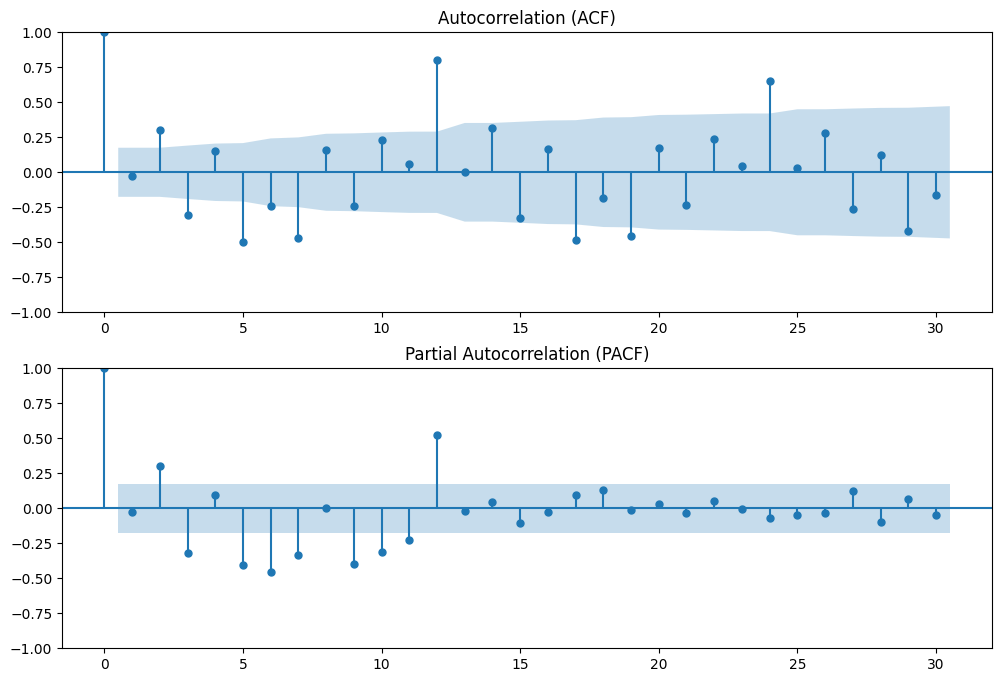

In [10]:
import statsmodels.api as sm

fig, ax = plt.subplots(2, 1, figsize=(12,8))

# Vẽ biểu đồ ACF (tự tương quan)
sm.graphics.tsa.plot_acf(df_monthly['Revenue_diff'].dropna(), lags=30, ax=ax[0])
ax[0].set_title("Autocorrelation (ACF)")

# Vẽ biểu đồ PACF (tự tương quan riêng phần)
sm.graphics.tsa.plot_pacf(df_monthly['Revenue_diff'].dropna(), lags=30, ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF)")

plt.show()

* ACF và PACF đều có đỉnh cao nhất ở lag 12 → Chuỗi có tính mùa vụ hàng năm (12 tháng).
* PACF có giá trị cao ở lag 12 → Mô hình có thể cần một thành phần autoregressive (AR) cho chu kỳ mùa vụ.

# 2. Xây dựng mô hình SARIMA

## 2.1. Huấn luyện mô hình

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_monthly = df_monthly.set_index('Date')
df_monthly = df_monthly['Revenue']  # Chỉ lấy cột doanh thu

# Đảm bảo dữ liệu có tần suất tháng
df_monthly = df_monthly.asfreq('ME')

In [21]:
df_monthly.head()

Date
2010-07-31    36351952.56
2010-08-31    47303856.18
2010-09-30    34881766.29
2010-10-31    32132565.36
2010-11-30    27462497.58
Freq: ME, Name: Revenue, dtype: float64

In [22]:
# Xây dựng mô hình SARIMA với tham số (p=1, d=1, q=1) và (P=1, D=1, Q=1, s=12)
sarima_model = SARIMAX(df_monthly, 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

# Huấn luyện mô hình
sarima_result = sarima_model.fit()

# In kết quả
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                  126
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1683.016
Date:                            Thu, 13 Feb 2025   AIC                           3376.033
Time:                                    00:20:59   BIC                           3389.008
Sample:                                07-31-2010   HQIC                          3381.283
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4057      0.181     -2.237      0.025      -0.761      -0.050
ma.L1         -0.0171      0.199   

In [23]:
from pmdarima import auto_arima

# Chạy Auto ARIMA để tìm tham số tốt nhất
model_auto = auto_arima(df_monthly, seasonal=True, m=12, trace=True, suppress_warnings=True)
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4340.180, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4419.467, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4350.753, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4370.345, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4417.488, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4354.978, Time=0.31 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4338.549, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=4392.074, Time=0.11 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=4340.217, Time=0.62 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=4342.178, Time=0.94 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=4339.644, Time=0.16 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=4338.857, Time=0.13 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=4336.995, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=4376.693, Time=0.11 sec
 ARIMA(3,1,2)(2,0,0

## 2.2. Đánh giá mô hình

In [26]:
df_test_monthly = df_test.groupby(pd.Grouper(key='Date', freq='ME')).agg({'Revenue': 'sum'}).reset_index()

# Sắp xếp lại dữ liệu theo thời gian
df_test_monthly = df_test_monthly.set_index('Date')

df_test_monthly.head()

,Revenue
Date,
2021-01-31,17404126.74
2021-02-28,22244195.61
2021-03-31,32252658.48
2021-04-30,42042708.54
2021-05-31,44448474.42


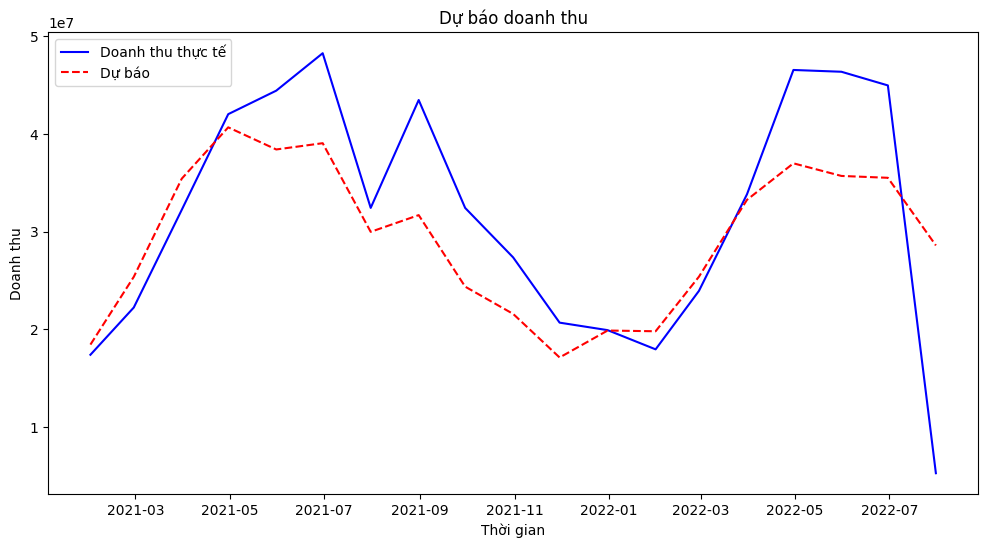

In [27]:
# Dự báo doanh thu
forecast = model_auto.predict(n_periods=len(df_test_monthly))

# Tạo dataframe chứa dữ liệu dự báo
df_forecast = pd.DataFrame(forecast, index=df_test_monthly.index, columns=['Forecast'])

# Kết hợp dữ liệu thực tế và dự báo
df_compare = df_test_monthly.join(df_forecast)

# Vẽ biểu đồ dự báo
plt.figure(figsize=(12,6))

plt.plot(df_compare.index, df_compare['Revenue'], label='Doanh thu thực tế', color='blue')
plt.plot(df_compare.index, df_compare['Forecast'], label='Dự báo', color='red', linestyle='--')

plt.title("Dự báo doanh thu")
plt.xlabel("Thời gian")
plt.ylabel("Doanh thu")
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Lấy giá trị thực tế và giá trị dự báo
y_true = df_compare['Revenue'].dropna()
y_pred = df_compare['Forecast'].dropna()

# Tính các độ đo
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to %
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Hiển thị kết quả
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")

R-squared: 0.5589
MAPE: 36.25%
RMSE: 8094308.66


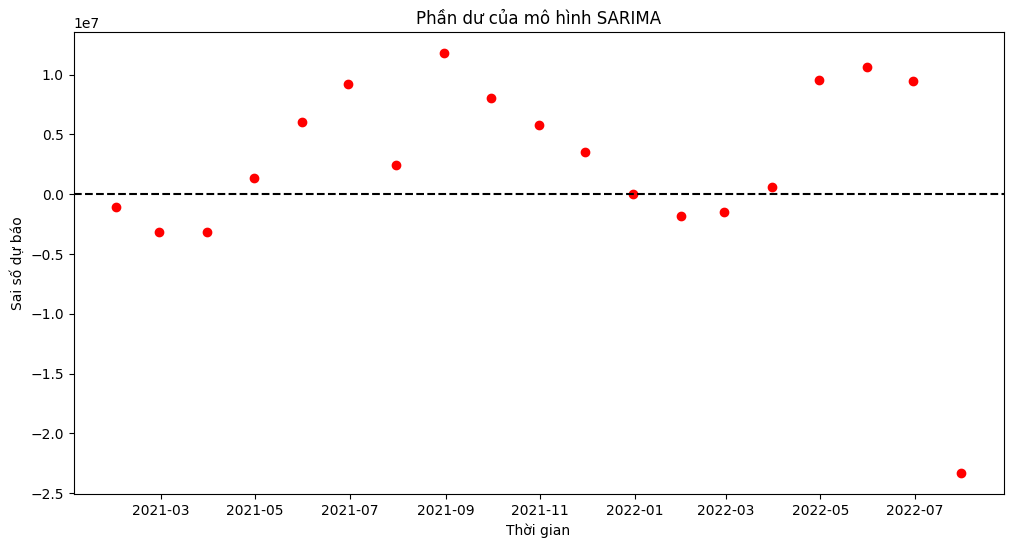

In [29]:
residuals = y_true - y_pred

# Vẽ biểu đồ phần dư
plt.figure(figsize=(12,6))
plt.plot(residuals, marker='o', linestyle='None', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Phần dư của mô hình SARIMA")
plt.xlabel("Thời gian")
plt.ylabel("Sai số dự báo")
plt.show()